In [7]:
#####################################################################
#                   example 5 (DEPRECATED)                          #
#    In this script we demonstrate how to use QuSpin's to build     #
#    the Hamiltonian of the SSH model in real and momentum space.   #
#    Along the way, we showcase the block tools which allow the     #
#    user to create block-diagonal Hamiltonians. Last, we show      #
#    how to time-evolve free fermion states like the Fermi sea      #
#    and measure correlators.                                       #
#####################################################################
from quspin.operators import hamiltonian, exp_op  # Hamiltonians and operators
from quspin.basis import spinless_fermion_basis_1d  # Hilbert space fermion basis
from quspin.tools.block_tools import block_diag_hamiltonian  # block diagonalisation
import time
from quspin.tools.evolution import expm_multiply_parallel
import numpy as np  # generic math functions
import matplotlib.pyplot as plt  # plotting library
from quspin.operators import commutator

from scipy.sparse.linalg import eigs
##### define model parameters #####
L = 14  # system size
J = 1.0  # uniform hopping
mu = 0.0 # bond dimerisation
Delta = 1.0  # staggered potential
delta = 0.5
##### construct single-particle Hamiltonian #####
# define site-coupling lists
hop_pm = [[-J , i, (i + 1) % L] for i in range(L)]  
hop_mp = [[+J , i, (i + 1) % L] for i in range(L)]  
hop_mm = [[Delta + (-1)**i*delta , i, (i + 1) % L] for i in range(L)]  
hop_pp = [[-Delta + (-1)**i*delta , i, (i + 1) % L] for i in range(L)]  
stagg_pot = [[2*mu , i] for i in range(L)]
# define static and dynamic lists
static = [["+-", hop_pm], ["-+", hop_mp],["++", hop_pp],["--", hop_mm], ["z", stagg_pot]]
dynamic = []
# define basis


basis = spinless_fermion_basis_1d(L, Nf=range(0, L+1, 2)) 
# build real-space Hamiltonian
H_sum = hamiltonian(static, dynamic, basis=basis, dtype=np.complex128,check_pcon=False,check_symm=False,check_herm=False)

static = [["I", [[1. , i] for i in [1]]]]  # 恒等算符
Identity = hamiltonian(static, [], basis=basis, dtype=np.float64,check_symm=False,check_herm=False)


##### construct single-particle Hamiltonian #####
# define site-coupling lists
hop_pm = [[-J , i, (i + 1) % L] for i in range(L)]  
hop_mp = [[+J , i, (i + 1) % L] for i in range(L)]  
hop_mm = [[Delta , i, (i + 1) % L] for i in range(L)]  
hop_pp = [[-Delta , i, (i + 1) % L] for i in range(L)]  
stagg_pot = [[2*mu , i] for i in range(L)]
# define static and dynamic lists
static = [["+-", hop_pm], ["-+", hop_mp],["++", hop_pp],["--", hop_mm], ["z", stagg_pot]]
dynamic = []
# define basis


# build real-space Hamiltonian
H_Kitaev = hamiltonian(static, dynamic, basis=basis, dtype=np.complex128,check_pcon=False,check_symm=False,check_herm=False)



# 假设 H 是 QuSpin 的 Hamiltonian 对象
H_mat = H_sum.tocsc()  # 转换为稀疏矩阵（CSC 格式）


eigenvalues, eigenvectors = eigs(H_mat, k=1,  which='LI')  # 'LR' 表示最大实部
print(eigenvalues)

[-1.83186799e-15+4.49395921j]


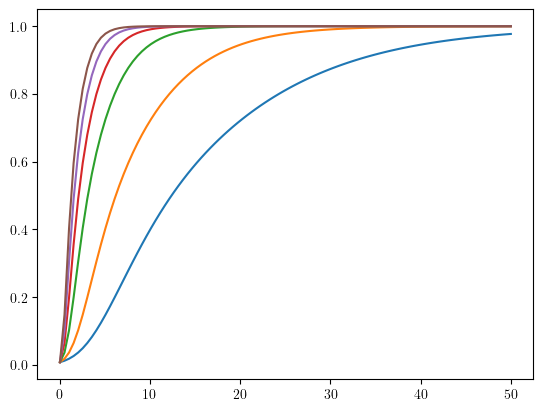

In [13]:


# L_impurity = 10

# hop_mm = [[+ (-1)**i*delta , i, (i + 1) ] for i in range(L_impurity)]  
# hop_pp = [[(-1)**i*delta, i, (i + 1) ] for i in range(L_impurity)]  
# static = [["++", hop_pp],["--", hop_mm]]


# H_impurity = hamiltonian(static, dynamic, basis=basis, dtype=np.complex128,check_pcon=False,check_symm=False,check_herm=False)

# H_evolve = H_Kitaev + H_impurity

times = np.linspace(0,50,100)

A = '0'*L
i0 = basis.index(A)
psi_initial = np.zeros(basis.Ns, dtype=np.complex128)
psi_initial[i0] = 1.0
work_array = np.zeros((2 * len(psi_initial),), dtype=psi_initial.dtype)  

psi_i = psi_initial.copy()
t = times[1]-times[0]


# Overlap_Buffer = np.zeros((len(times),6))

delta = 0.5
yy = 5


psi_i = psi_initial.copy()
hop_pm = [[-J , i, (i + 1) % L] for i in range(L)]  
hop_mp = [[+J , i, (i + 1) % L] for i in range(L)]  
hop_mm = [[Delta + (-1)**i*delta , i, (i + 1) % L] for i in range(L)]  
hop_pp = [[-Delta + (-1)**i*delta , i, (i + 1) % L] for i in range(L)]  
stagg_pot = [[2*mu , i] for i in range(L)]

static = [["+-", hop_pm], ["-+", hop_mp],["++", hop_pp],["--", hop_mm], ["z", stagg_pot]]
dynamic = []
H_sum = hamiltonian(static, dynamic, basis=basis, dtype=np.complex128,check_pcon=False,check_symm=False,check_herm=False)
expH0 = expm_multiply_parallel(H_sum.tocsr(), a=-1j * t , dtype=np.complex128)

for xx,t in enumerate(times):
    
    Overlap_Buffer[xx,yy] = np.abs(np.vdot(psi_i,eigenvectors[:,0]))**2

    expH0.dot(psi_i, work_array=work_array, overwrite_v=True)
    psi_i = psi_i/np.sqrt(np.vdot(psi_i,psi_i))



plt.plot(times, Overlap_Buffer)


In [14]:
np.savez('fig5.npz',Overlap_Buffer= Overlap_Buffer)

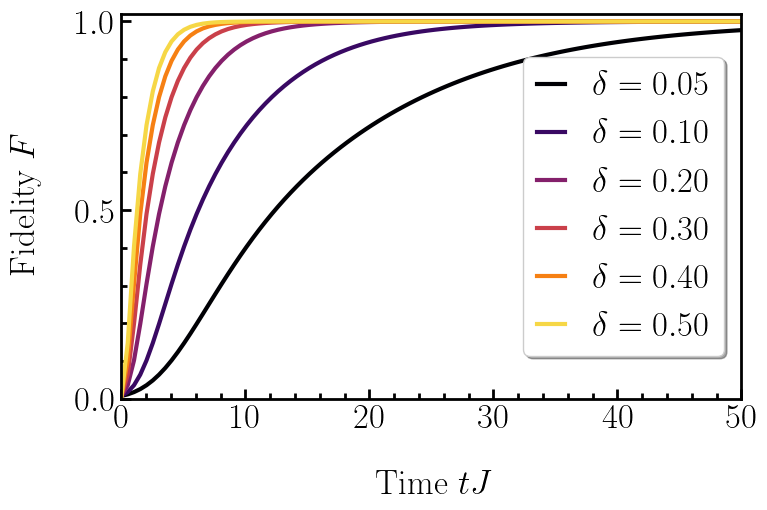

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
from matplotlib.colors import rgb2hex  # 正确导入 rgb2hex
from matplotlib.cm import plasma, inferno  # 直接导入 plasma 色条
from matplotlib.colors import Normalize
from matplotlib import cm

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
    "text.latex.preamble": r"\usepackage{amsmath}"
})
font_size = 25
MU_list = np.arange(-1.5, 1.5, 0.1)
delta_list = np.arange(-0.6, 0.6, 0.1)
AA = np.load('fig5.npz')
x = MU_list   # μ axis
y = delta_list  # δ axis
X, Y = np.meshgrid(x, y)
Z = AA['Overlap_Buffer']



# 生成12个均匀分布的颜色（0到1之间）
cmap = plt.get_cmap('inferno')  
hex_colors = [rgb2hex(cmap(i)) for i in np.linspace(0, 0.9, 6)]  # 避免最亮色重复
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
delta_list = [0.05,0.1,0.2,0.3,0.4,0.5]



for i in range(6):  # Plot 9 lines in 3D


    ax1.plot(times, Z[:,i], lw=3,c = hex_colors[i],label=r"$ \delta = %.2f$"%(delta_list[i]))

ax1.legend( loc="right", prop={'size': font_size },ncol=1,   shadow=True, handleheight=0.5, handlelength=0.8)
ax1.set_xlabel('Time $tJ$', size=font_size, labelpad=25)

ax1.set_ylabel('Fidelity $F$', size=font_size, labelpad=25)

ax1.tick_params(which='major', direction='in', length=7, width=2, labelsize=font_size)
ax1.xaxis.set_major_locator(MultipleLocator(10))
ax1.xaxis.set_minor_locator(MultipleLocator(2))
ax1.yaxis.set_major_locator(MultipleLocator(0.5))
ax1.yaxis.set_minor_locator(MultipleLocator(0.1))
ax1.set_ylim([0,1.02])
ax1.set_xlim([0,50])
# for i in range(1):
ax1.tick_params(which='minor',direction='in', length=4,width=2,axis = "both")
ax1.tick_params(which='major',direction='in', length=7,width=2,labelsize=font_size,axis = "both")
ax1.spines['bottom'].set_linewidth(2)
ax1.spines['top'].set_linewidth(2)
ax1.spines['right'].set_linewidth(2)
ax1.spines['left'].set_linewidth(2)
plt.savefig('fig5.pdf',transparent = True,bbox_inches = 'tight')


In [70]:
y

array([-6.00000000e-01, -5.00000000e-01, -4.00000000e-01, -3.00000000e-01,
       -2.00000000e-01, -1.00000000e-01, -1.11022302e-16,  1.00000000e-01,
        2.00000000e-01,  3.00000000e-01,  4.00000000e-01,  5.00000000e-01])